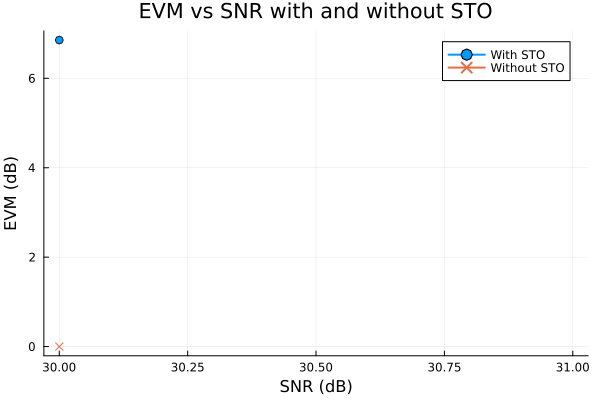

In [1]:
using FFTW, Random, Printf, Plots, Interpolations, Statistics

# Configurable simulation parameters
R = 32
T = 100
snrRange = [30]  # Single value for simplicity

stoError = -2
if stoError > 0
    error("STO error in samples MUST BE NEGATIVE")
end

cfoErrorHz = 0

# Non-configurable simulation parameter - DO NOT EDIT!
K = 72
L = 14
P = 12
ps = div(K, P)
kp = 1:ps:K
targetEvm = 50
combEnabled = true
constLimit = 2

# Function to compute EVM
function computeEVM(x_orig, x_est)
    e = x_orig .- x_est
    mse_error = abs2.(e)
    mse_signal = abs2.(x_orig)
    evm = 100 * sqrt(mean(mse_error) / mean(mse_signal))
    return evm
end

# Function to run OFDM transmission and reception
function runOFDM(snrRange, stoError, K, L, kp, P, R, T, cfoErrorHz, combEnabled)
    evm_snr = zeros(length(snrRange))
    
    for snrCnt in 1:length(snrRange)
        # Noise power
        N = 10^(-snrRange[snrCnt]/10)

        # Transmission
        # Generate QPSK symbols
        x = 1/sqrt(2) * ((2 * rand(Bool, K, L) .- 1) .+ 1im * (2 * rand(Bool, K, L) .- 1))

        # Assign pilots from symbols - these will be known to the receiver
        p = x[kp, :]

        # Save original QPSK symbols as reference for EVM estimation
        x_orig = copy(x)

        # IFFT, no DC
        cpLength = 9
        xTimeDomain = ComplexF64[0.0 + 0.0im for i in 1:(128 + cpLength), j in 1:L]
        for symbolCnt in 1:L
            freq_128bins = vcat(zeros(ComplexF64, 28), x[:, symbolCnt], zeros(ComplexF64, 28))
            freq_128bins = fftshift(freq_128bins)
            time_128samp = ifft(freq_128bins) * sqrt(128)
            cpSamples = time_128samp[end-cpLength+1:end]
            timeSymbol = vcat(cpSamples, time_128samp)
            xTimeDomain[:, symbolCnt] = timeSymbol
        end

        # Channel
        h = 1/sqrt(2) + 1/sqrt(2) * 1im

        # Reception
        evm_trans = zeros(T)  # Initialize storage for EVM of each transmission
        for t in 1:T
            # Initialize receive signal
            y = ComplexF64[0.0 + 0.0im for i in 1:K, j in 1:L]

            # Loop over repetitions
            evm_rep = zeros(R)  # Initialize storage for EVM of each repetition
            for r in 1:R
                # Generate complex Gaussian noise
                n = sqrt(N/2) * (randn(128 + cpLength, L) .+ 1im * randn(128 + cpLength, L))

                # Received signal in time domain
                yTime = h * xTimeDomain .+ n

                yr = ComplexF64[0.0 + 0.0im for i in 1:K, j in 1:L]
                for symbolCnt in 1:L
                    symbolTd = yTime[:, symbolCnt]

                    # Add CFO
                    samplingRate = 1.92e6
                    cfoPhaseRamp = 2 * π * cfoErrorHz / samplingRate
                    cfoSampleInit = (r - 1) * length(symbolTd) * L + (symbolCnt - 1) * length(symbolTd)
                    cfoVector = exp.(1im * cfoPhaseRamp * (0:length(symbolTd)-1 .+ cfoSampleInit))
                    cfoVector = cfoVector[1:length(symbolTd)]  # Ensure dimensions match
                    symbolTd = symbolTd .* cfoVector

                    # Detection 
                    symbolTd = symbolTd[cpLength+1+stoError:end+stoError]

                    # FFT and fftshift
                    symbolFd = fftshift(fft(symbolTd))

                    startSc = div(128 - 72, 2) + 1
                    yr[:, symbolCnt] = symbolFd[startSc:startSc+K-1]
                end

                # Repetition combining (or not)
                y = combEnabled ? y .+ yr : yr

                # Normalize the signal according to the repetition index
                y_norm = y / r

                # Extract pilot subcarriers from current signal
                yp = y_norm[kp, :] 

                # Least square channel estimation for pilots and average over symbols and subcarriers
                pilots = yp ./ p
                pilots_average = mean(pilots, dims=2)
                
                # Interpolation
                kp_float = float.(kp)
                interp_real = LinearInterpolation(kp_float, real(pilots_average[:]), extrapolation_bc=Line())
                interp_imag = LinearInterpolation(kp_float, imag(pilots_average[:]), extrapolation_bc=Line())
                vq_real = interp_real(1:K)
                vq_imag = interp_imag(1:K)
                vq = vq_real .+ 1im .* vq_imag
                
                # Plot interpolation results for verification
                plot(kp, angle.(pilots_average[:]), label="Pilots Average Angle", marker=:o)
                plot!(1:K, angle.(vq), label="Linear Interpolation Angle", linestyle=:dash)
                title!("(Default) Linear Interpolation")
                xlabel!("Subcarrier Index")
                ylabel!("Angle (radians)")
                # grid!(true)

                # Zero-forcing equalization
                x_est = y_norm ./ vq

                # Calculate Error Vector Magnitude (EVM) per repetition
                evm_rep[r] = computeEVM(x_orig, x_est)
            end

            # Calculate EVM per transmission
            evm_trans[t] = mean(evm_rep)
        end

        # Calculate EVM per SNR
        evm_snr[snrCnt] = mean(evm_trans)
    end
    
    return evm_snr
end

# Run simulations with and without STO
evm_snr_sto = runOFDM(snrRange, stoError, K, L, kp, P, R, T, cfoErrorHz, combEnabled)
evm_snr_no_sto = runOFDM(snrRange, 0, K, L, kp, P, R, T, cfoErrorHz, combEnabled)

# Plot EVM vs SNR
plot(snrRange, 10 * log10.(evm_snr_sto), label="With STO", marker=:o, linewidth=2)
plot!(snrRange, 10 * log10.(evm_snr_no_sto), label="Without STO", marker=:x, linewidth=2)
xlabel!("SNR (dB)")
ylabel!("EVM (dB)")
title!("EVM vs SNR with and without STO")
# grid!(true)
